## DQN & DDQN Implementation Exercise
Before beginning this exercise, we highly recommend you read through the [DQN Derivation](dqn_derivation.ipynb) tutorial to get a better grasp of the math behind DQN.

Initializing the environment:

In [1]:
import metadrive  # Import this package to register the environment!
import gymnasium as gym

env = gym.make("MetaDrive-validation-v0", config={"use_render": False})
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})

# Alternatively, you can instantiate using the class
# env = metadrive.MetaDriveEnv(config={"use_render": True, "num_scenarios": 100})

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


### Creating the model

In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

class DQNModel(nn.Module):
    def __init__(self, observation_size = 259, action_size = 4, hidden_size = 256):
        super().__init__()
        # Create a fully connected network with 3 or more layers using nn.Linear
        # First layer is filled out for you:
        self.fc1 = nn.Linear(observation_size, hidden_size)

        # TODO: Fill out the rest of the network!
        # Hint: All layers except the first and last layers have input shape hidden_size and output shape hidden_size
        # Last layer has input shape hidden_size and output shape action_size
    def forward(self, x):
        # TODO: Implement the forward function, calling the layers you created in __init__
        # Hint: Use F.relu for the activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Note: Don't add an activation to the last layer. 

<details><summary>Why not?</summary>

Our network needs to output a tensor that represents the quality of each action available in the agent's current state, and we don't want to put any artificial bounds on the range of possible qualities for a state-action pair.
</details>


As a refresher, here's the Bellman equation from the derivation notebook:

- If the current step isn't the last step:
$$Q^{\pi}(s_t, a_t) \leftarrow \left(r_{t+1} + \underset{a \in A}{\operatorname{argmax}} Q^{\pi}(s_{t+1}, a) \right)$$
- If the current step is the last step:
$$Q^{\pi}(s_t, a_t) \leftarrow r_{t+1}$$

In [4]:
class DQN:
    def __init__(self, model, lr = 0.001, gamma = 0.99, epsilon = 0.1):
        self.model = model
        self.gamma = gamma
        self.epsilon = epsilon
        self.optimizer = t.optim.Adam(model.parameters(), lr = lr)
        self.loss = nn.MSELoss()        

    def convert_to_tensor(self, items):
        return [t.tensor(item, dtype = t.float32) for item in items]

    def train(self, state, action, next_state, reward, done):
        state, action, next_state, reward, done = self.convert_to_tensor([
            state, action, next_state, reward, done])
        
        # Here, we have a training function that takes in batches of data.
        # The arguments of the function - state, action, next_state, reward, done - are all batched tensors.

        # 1. TODO: Get the Q values of the current state and next state using the model



        # 2. TODO: Calculate the expected Q value using the Bellman equation


        
        # 3. Update the model to minimize the loss between the Q value and the expected Q value.

        """ The reason we use detach is because we don't want to propagate the gradient
         of the expected Q value - we don't want to update the model to fit the expected
         Q value to the real Q value, only the other way around."""
        loss = self.loss(q_value, expected_q_value.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def act(self, state, epsilon = None):
        epsilon = epsilon if epsilon is not None else self.epsilon
        # TODO: Implement the act function using the epsilon-greedy algorithm.

        # Explore if random number is greater than epsilon, otherwise exploit


In order to use a DQN, we need to discretize the action space.
<details><summary>Why?</summary>

$$Q^{\pi}(s_t, a_t) \leftarrow \left(r_{t+1} + \argmax_{a \in A} Q^{\pi}(s_{t+1}, a) \right)$$

- The above update rule also only works in discretized environments, as $\argmax_{a \in A} Q^{\pi}(s_{t+1}, a)$ is intractable to calculate if there are infinite possible actions.
</details>
 Let us do this by dividing the range of possible actions into 4 discrete actions:

- 0: [-1, 0] - Brake
- 1: [0, -1] - Turn
- 2: [0, 1] - Turn
- 3: [1, 0] - Accelerate forward
- 4: [0, 0] - Do nothing

In [5]:
def discrete_action_to_continuous(action: int):
    if action == 0:
        return [-1, 0]
    elif action == 1:
        return [0, -1]
    elif action == 2:
        return [0, 1]
    elif action == 3:
        return [1, 0]
    assert action < 4 and action > 0, "Unknown action: {}".format(action)

### Replay Buffer

Replay buffers, also known as experience replay, are key components in making DQNs stable and efficient. The main idea behind replay buffers is to store the agent’s experiences at each time step, then randomly draw a batch of experiences to train the network.

Each experience, or transition, typically includes $s_t$, $a_t$, $r_{t_1}$, $s_{t+1}$ - the four elements necessary to update the model using the Bellman Equation, and *done*, a boolean indicating if the state is a terminal one.

The use of replay buffers has several benefits:
- Breaking the correlation between consecutive experiences: In a typical episode, consecutive experiences are highly correlated. By sampling experiences randomly from the replay buffer, we can break this correlation, which leads to more stable and effective learning.

- Reusing past experiences: Without a replay buffer, an agent’s experiences would be used only once to update the network and then discarded. With a replay buffer, we can reuse past experiences, making the learning process more efficient.

- Improving sample efficiency: By storing and reusing experiences, the replay buffer can help the agent learn more from fewer interactions with the environment.


In [6]:
class ReplayBuffer():
    def __init__(self, capacity = 10000):
        # TODO: Write the methods below to implement a replay buffer
        # Note: Once capacity is reached, the buffer should overwrite the oldest data

    def push(self, state, action, next_state, reward, done):

    def sample(self, batch_size = 32):
        # Should return a tuple of tensors with dimension [0] of batch_size in the order of:
        # return state, action, next_state, reward, done

    def __len__(self):


### Training Loop

In [162]:
model = DQNModel()
DQNlearner = DQN(model)
replay_buffer = ReplayBuffer()

In [ ]:
from tqdm import tqdm, trange

MAX_STEPS_PER_EPISODE = 2000
MAX_EPISODES = 1000
TRAIN_STEPS_PER_EPISODE = 50

history = []
with trange(MAX_EPISODES) as pbar:
    for ep in pbar:
        # Implement the training loop (remember to use the replay buffer!)

        # 1. TODO: Reset the environment and get the initial observation

        for i in range(MAX_STEPS_PER_EPISODE):
            # 2. TODO: Get the action using the act function of the DQN learner
            # 3. TODO: Convert the discrete action to a continuous action (using the discrete_action_to_continuous function)
            # 4. TODO: Step forward with the environment.
            # 5. TODO: Add to the training buffer.
            # 6. TODO: Stop if environment has been terminated or truncated.

        # 7. TODO: Train the DQN learner using the replay buffer once every N steps.
        # 8. Bonus TODO: Save the total reward of each episode to history.
    

<Axes: >

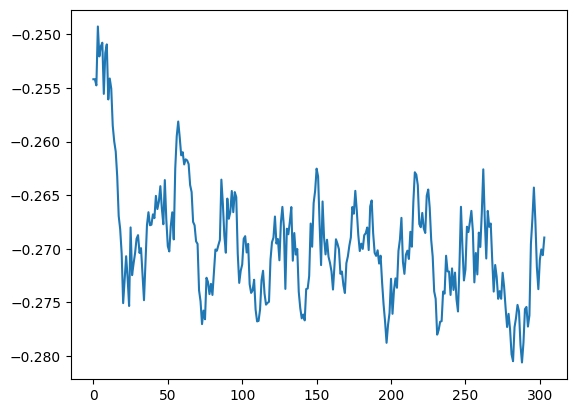

In [17]:
import seaborn as sns

# Visualize the training progress (bonus)
ema_plot = []
ema = history[0]; ema_plot.append(ema)
for i in range(len(history)):
    ema = 0.9 * ema + 0.1 * history[i]
    ema_plot.append(ema)
sns.lineplot(ema_plot)

### Double Dueling DQN

In [7]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy

class DDQN:
    def __init__(self, model, lr = 0.001, gamma = 0.95, epsilon = 0.1):
        self.model = model
        self.gamma = gamma
        self.epsilon = epsilon
        self.optimizer = t.optim.Adam(model.parameters(), lr = lr)
        self.loss = nn.MSELoss()
        self.target_model = DQNModel()
        self.update_target()
        # Make the target model a copy of the original model.   

    def convert_to_tensor(self, items):
        return [t.tensor(item, dtype = t.float32) for item in items]

    def update_target(self):
        self.target_model.load_state_dict(copy.deepcopy(self.model.state_dict()))

    def train(self, state, action, next_state, reward, done):
        state, action, next_state, reward, done = self.convert_to_tensor([
            state, action, next_state, reward, done])
            
        q_values = self.model(state)
        next_q_values = self.target_model(next_state)

        # Bellman equation: Q(s,a) = r + gamma * max_a' Q(s',a')

        # First, find the Q value of the specific action we took.
        q_value = q_values.gather(1, action.unsqueeze(1).long()).squeeze(1)

        # Next, find the maximum Q value of the next state.
        next_q_value = next_q_values.max(1)[0]

        # Update the Q value of the current state using the Bellman Equation.
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)

        """ The reason we use detach is because we don't want to propagate the gradient
         of the expected Q value - we don't want to update the model to fit the expected
         Q value to the real Q value, only the other way around."""
        loss = self.loss(q_value, expected_q_value.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def act(self, state, epsilon = None):
        epsilon = epsilon if epsilon is not None else self.epsilon
        if random.random() > epsilon:
            state = t.tensor(state[np.newaxis:], dtype = t.float32)
            q_value = self.model(state)
            action = q_value.argmax().item()
        else:
            action = random.randint(0, 3)
        return action

In [23]:
model = DQNModel()
DQNlearner = DDQN(model, lr=1e-3)
replay_buffer = ReplayBuffer()
model.load_state_dict(t.load("ddqn_trained_1000_steps"))

<All keys matched successfully>

In [24]:
from tqdm import tqdm, trange

MAX_STEPS_PER_EPISODE = 2000
MAX_EPISODES = 10000
TRAIN_STEPS_PER_EPISODE = 50
UPDATE_TARGET_EVERY = 50
BATCH_SIZE = 128

history = []
with trange(MAX_EPISODES) as pbar:
    for ep in pbar:
        total_reward = 0
        obs, info = env.reset()

        for i in range(MAX_STEPS_PER_EPISODE):
            action = DQNlearner.act(obs, epsilon=0.2)
            #action = 2
            action_continuous = discrete_action_to_continuous(action)

            new_obs, reward, terminated, truncated, info = env.step(action_continuous)
            total_reward += reward
            replay_buffer.push(obs, action, new_obs, reward, terminated)
            obs = new_obs
            if terminated or truncated:
                break

        total_loss = 0
        if len(replay_buffer) > BATCH_SIZE:
            for i in range(TRAIN_STEPS_PER_EPISODE):
                total_loss += DQNlearner.train(*replay_buffer.sample(BATCH_SIZE))

        if ep % UPDATE_TARGET_EVERY == 0:
            DQNlearner.update_target()
        
        history.append(total_reward)
        pbar.set_description(f"Episode {ep} | Reward: {round(total_reward, 4)} | Loss: {round(total_loss / TRAIN_STEPS_PER_EPISODE, 5)}")

  0%|          | 0/10000 [00:00<?, ?it/s]INFO:c:\Users\william\Desktop\Software\Development\Projects\metadrive\metadrive\metadrive\envs\base_env.py:Episode ended! Reason: out_of_road.
Episode 0 | Reward: 13.5684 | Loss: 0.0:   0%|          | 1/10000 [00:00<1:05:42,  2.54it/s]INFO:c:\Users\william\Desktop\Software\Development\Projects\metadrive\metadrive\metadrive\envs\base_env.py:Episode ended! Reason: out_of_road.
Episode 1 | Reward: 108.2919 | Loss: 3.41618:   0%|          | 2/10000 [00:01<2:52:23,  1.03s/it]INFO:c:\Users\william\Desktop\Software\Development\Projects\metadrive\metadrive\metadrive\envs\base_env.py:Episode ended! Reason: out_of_road.
Episode 2 | Reward: 42.2224 | Loss: 2.78217:   0%|          | 3/10000 [00:02<2:48:59,  1.01s/it] INFO:c:\Users\william\Desktop\Software\Development\Projects\metadrive\metadrive\metadrive\envs\base_env.py:Episode ended! Reason: out_of_road.
Episode 3 | Reward: 7.2641 | Loss: 3.0962:   0%|          | 4/10000 [00:03<2:22:46,  1.17it/s]  INFO:

In [25]:
model(t.tensor(obs[np.newaxis:], dtype = t.float32))

tensor([8.7031, 5.6386, 4.9396, 1.1610], grad_fn=<AddBackward0>)

<Axes: >

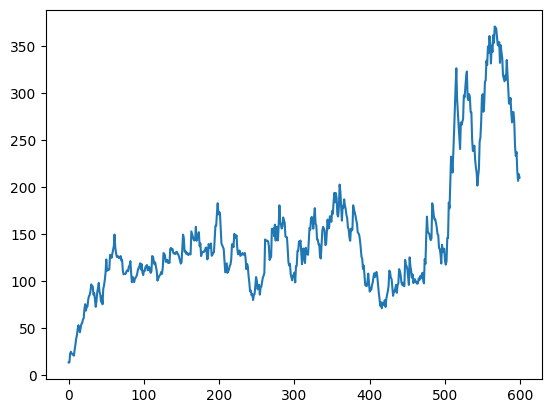

In [27]:
import seaborn as sns
ema_plot = []
ema = history[0]; ema_plot.append(ema)
for i in range(len(history)):
    ema = 0.9 * ema + 0.1 * history[i]
    ema_plot.append(ema)
sns.lineplot(ema_plot[:600])

## Inference

In [1]:
import metadrive  # Import this package to register the environment!
import gymnasium as gym

env = gym.make("MetaDrive-validation-v0", config={"use_render": True})

# Alternatively, you can instantiate using the class
# env = metadrive.MetaDriveEnv(config={"use_render": True, "num_scenarios": 100})

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


In [9]:
model = DQNModel()
model.load_state_dict(t.load("ddqn_trained_1000_steps"))
DQNlearner = DDQN(model)

In [11]:
from tqdm import tqdm, trange

MAX_STEPS_PER_EPISODE = 10000
total_reward = 0
obs, info = env.reset()
for i in range(MAX_STEPS_PER_EPISODE):
    action = DQNlearner.act(obs, epsilon = 0.3)
    action_continuous = discrete_action_to_continuous(action)
    obs, reward, terminated, truncated, info = env.step(action_continuous)
    total_reward += reward

    if terminated or truncated:
        break

INFO:c:\Users\william\Desktop\Software\Development\Projects\metadrive\metadrive\metadrive\envs\base_env.py:Episode ended! Reason: out_of_road.
